In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
macau = pd.read_csv('Macau-2022.csv', index_col='date', parse_dates = ['date'])
macau = macau.fillna(method="ffill")
macau.head()

,arrival
date,
2011-01-01,2076066
2011-02-01,2164249
2011-03-01,2190865
2011-04-01,2338449
2011-05-01,2295551


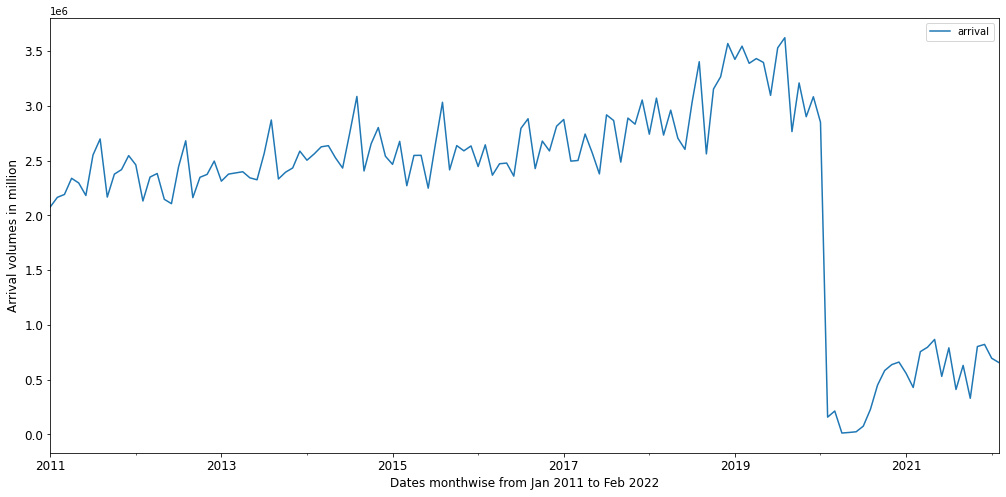

In [3]:
macau.plot(y='arrival', subplots=True, figsize=(17,8), fontsize=12)
plt.xlabel('Dates monthwise from Jan 2011 to Feb 2022',fontsize=12)
plt.ylabel('Arrival volumes in million',fontsize=12)
plt.show()

In [4]:
train_start_dt = '2011-01-01'
test_start_dt = '2021-01-01'

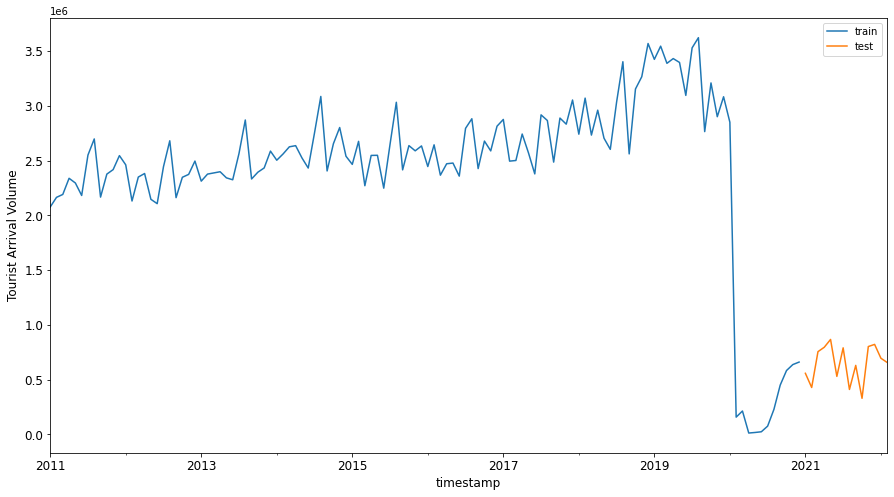

In [5]:
macau[(macau.index < test_start_dt) & (macau.index >= train_start_dt)][['arrival']].rename(columns={'arrival':'train'}) \
    .join(macau[test_start_dt:][['arrival']].rename(columns={'arrival':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Tourist Arrival Volume', fontsize=12)
plt.show()

In [6]:
train = macau.copy()[(macau.index >= train_start_dt) & (macau.index < test_start_dt)][['arrival']]
test = macau.copy()[macau.index >= test_start_dt][['arrival']]

print('Shape of the training data: ', train.shape)
print('Shape of the test data: ', test.shape)

Shape of the training data:  (120, 1)
Shape of the test data:  (14, 1)


In [7]:
scaler = MinMaxScaler()
train['arrival'] = scaler.fit_transform(train)

In [8]:
test['arrival'] = scaler.transform(test)

In [9]:
train_data = train.values
test_data = test.values

In [10]:
timesteps=3

In [11]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(118, 3)

In [12]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(12, 3)

In [13]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(118, 2) (118, 1)
(12, 2) (12, 1)


In [14]:
model = SVR(kernel='linear', gamma=0.5, C=35, epsilon=0.05)

In [15]:
model.fit(x_train, y_train[:,0])

SVR(C=35, epsilon=0.05, gamma=0.5, kernel='linear')

In [16]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(118, 1) (12, 1)


In [17]:
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

118 12


In [18]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

118 12


In [19]:
train_timestamps = macau[(macau.index < test_start_dt) & (macau.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = macau[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

118 12


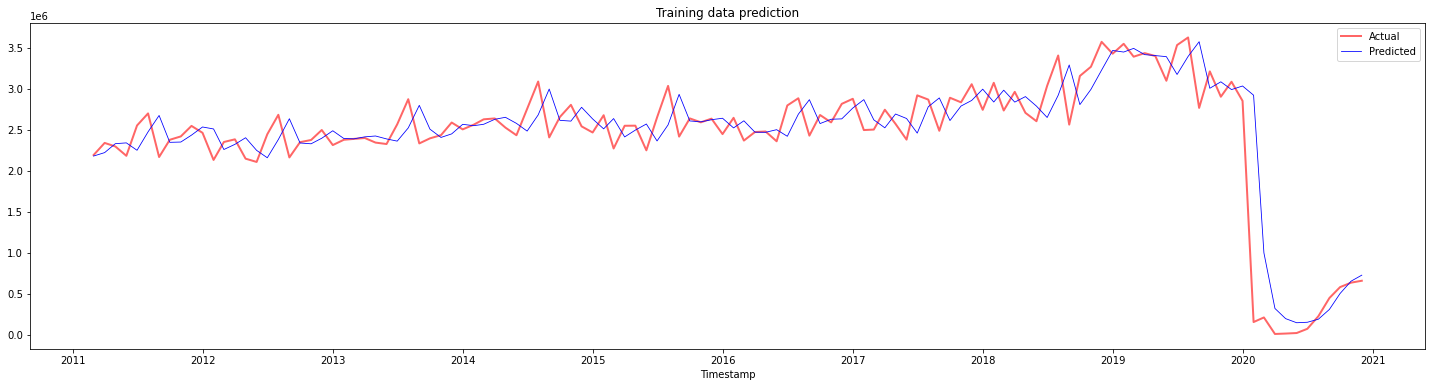

In [20]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [21]:
print('MAPE for training data: ', mean_absolute_percentage_error(y_train_pred, y_train))

MAPE for training data:  0.11626356166951497


In [22]:
print('RMSE for training data: ', math.sqrt(mean_squared_error(y_train_pred, y_train)))

RMSE for training data:  362483.30221585743


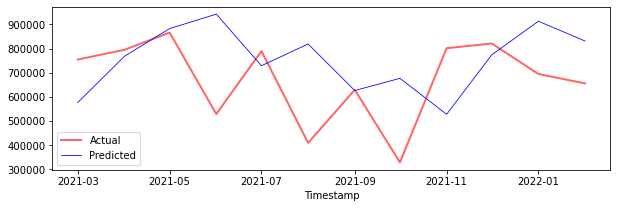

In [23]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [24]:
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test_pred, y_test))

MAPE for testing data:  0.24466840968084366


In [25]:
print('RMSE for testing data: ',math.sqrt(mean_squared_error(y_test_pred, y_test)))

RMSE for testing data:  233238.11162003005


In [26]:
data = macau.copy().values

data = scaler.transform(data)

data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (132, 3)
X shape:  (132, 2) 
Y shape:  (132, 1)


In [27]:
Y_pred = model.predict(X).reshape(-1,1)

Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

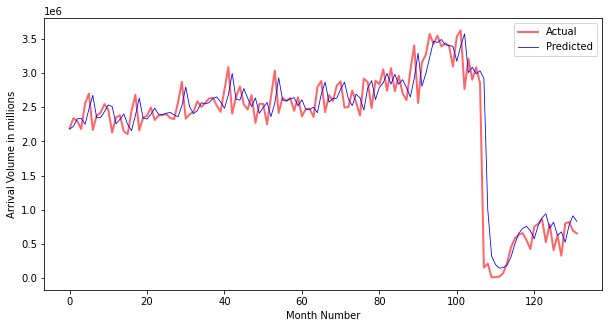

In [28]:
plt.figure(figsize=(10,5))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Month Number')
plt.ylabel('Arrival Volume in millions')
plt.show()

In [29]:
print('MAPE for SVR on Mt.Siguniang: ', mean_absolute_percentage_error(Y_pred, Y))

MAPE for SVR on Mt.Siguniang:  0.1310933753690869


In [30]:
print('RMSE for SVR on Mt.Siguniang: ', math.sqrt(mean_squared_error(Y_pred, Y)))

RMSE for SVR on Mt.Siguniang:  351064.98481989774


# Prediction

In [40]:
yhat = model.predict([[820870, 694430], [694430, 655505], [655505, 526912]]).reshape(-1,1)
print('-------------------------------')
print("Prediction for Feb 2022: ", int(yhat[0][0]))
print("MAPE for Feb 2022: %.2f " % (abs(655505 - yhat[0][0])/655505))
print('-------------------------------')
print("Prediction for March 2022: ", int(yhat[1][0]))
print("MAPE for March 2022: %.2f " % (abs(526912 - yhat[1][0])/526912))
print('-------------------------------')
print("Prediction for April 2022: ", int(yhat[2][0]))

-------------------------------
Prediction for Feb 2022:  697221
MAPE for Feb 2022: 0.06 
-------------------------------
Prediction for March 2022:  636759
MAPE for March 2022: 0.21 
-------------------------------
Prediction for April 2022:  537711
